#  Imports


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.applications import Xception, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.metrics import f1_score


import seaborn as sns
import matplotlib.pyplot as plt
import os

# Function Definitions

In [2]:
def train_val_generators(train_dir, val_dir):
    train_gen = ImageDataGenerator(rescale=1/255., horizontal_flip=True, vertical_flip=True, zoom_range=0.2)
    train_generator = train_gen.flow_from_directory(directory=train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

    val_gen = ImageDataGenerator(rescale=1/255.)
    val_generator = val_gen.flow_from_directory(directory=val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

    return train_generator, val_generator


def train_model(model, train_generator, val_generator, epochs=15):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[callback])

    return history


In [3]:
def assign_labels(test_generator, model, print_info=True):
    test_labels = []
    pred_labels = []

    for batch in range(0, int(len(test_generator))):
        batch_predicted = model.predict(test_generator[batch][0])
        for i in range(len(batch_predicted)):
            pred_label = np.argmax(batch_predicted[i])
            true_label = np.argmax(test_generator[batch][1][i])
            true_name = bc_types[true_label]  # Decode true label to category
            pred_name = bc_types[pred_label]  # Decode predicted label to category
            true_category = dict_bc[bc_dict[true_name]]  # Use bc_dict to get the value and then access dict_bc
            pred_category = dict_bc[bc_dict[pred_name]]  # Use bc_dict to get the value and then access dict_bc

            pred_labels.append(pred_category)
            test_labels.append(true_category)

            if print_info:
                print(f"Imagen {batch * len(batch_predicted) + i + 1} - Verdadero: {true_category} ( {true_name} ), Predicho: {pred_category} ( {pred_name} )")

    return test_labels, pred_labels

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plotear el historial de entrenamiento
    eps = range(len(history.history["loss"]))
    plt.figure(figsize=(10, 6))
    plt.plot(eps, history.history["loss"])
    plt.plot(eps, history.history["val_loss"])
    plt.legend(["loss", "val_loss"])
    plt.title('Training History - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    # Plotear la precisión
    plt.figure(figsize=(10, 6))
    plt.plot(eps, history.history["accuracy"])
    plt.plot(eps, history.history["val_accuracy"])
    plt.legend(["accuracy", "val_accuracy"])
    plt.title('Training History - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

def check_precision(model, test_generator):
    # Asignar e imprimir etiquetas
    test_labels, pred_labels = assign_labels(test_generator, model, print_info=False)

    # Imprimir la matriz de confusión y la precisión
    cm = confusion_matrix(test_labels, pred_labels)
    accuracy = accuracy_score(test_labels, pred_labels)

    print("Matriz de Confusión:")
    print(cm)
    print("Precisión:", accuracy)
    return cm





In [5]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusión')
    plt.xlabel('Etiquetas Predichas')
    plt.ylabel('Etiquetas Verdaderas')
    plt.show()

# Configuracion inicial

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:

# Directorio base después de montar el drive
base_path = '/content/drive/My Drive/DataSet'

# Listar archivos en el directorio base
files = os.listdir(base_path)

path_root = '/content/drive/My Drive/DataSet'

valid_dir = os.path.join(path_root, 'val')
train_dir = os.path.join(path_root, 'train')
test_dir = os.path.join(path_root, 'test')

In [8]:
bc_types = [file for file in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, file))]
print("Types: ", bc_types)

# to encode labels
bc_dict = {'InSitu': 3, 'Benign': 2, 'Normal': 1, 'Invasive': 4}
print("Encode: ", bc_dict)

# to decode labels
dict_bc = {1: "Normal", 2: "Benign", 3: "InSitu", 4: "Invasive"}
print("Decode: ", dict_bc)

classes = [dict_bc[i] for i in sorted(dict_bc.keys())]


Types:  ['InSitu', 'Benign', 'Normal', 'Invasive']
Encode:  {'InSitu': 3, 'Benign': 2, 'Normal': 1, 'Invasive': 4}
Decode:  {1: 'Normal', 2: 'Benign', 3: 'InSitu', 4: 'Invasive'}


In [9]:
# Set IMG_SIZE and BATCH_SIZE
IMG_SIZE = (512, 512)
BATCH_SIZE = 8
NUM_CLASES = 4


In [10]:
import imghdr  # Importar el módulo imghdr para verificar el tipo de imagen

# Calcular el rango de píxeles en lugar de asumir que es 255
pixel_min = float('inf')  # Inicializar con un valor grande
pixel_max = float('-inf')  # Inicializar con un valor pequeño

# Iterar sobre las imágenes en el conjunto de entrenamiento para encontrar el rango real
for root, dirs, files in os.walk(train_dir):
    for file in files:
        img_path = os.path.join(root, file)

        # Verificar si el archivo es una imagen
        if imghdr.what(img_path) is not None:
            img = plt.imread(img_path)
            img_min = np.min(img)
            img_max = np.max(img)
            pixel_min = min(pixel_min, img_min)
            pixel_max = max(pixel_max, img_max)

In [11]:
pixel_min

0

In [12]:
train_generator, val_generator = train_val_generators(train_dir, valid_dir)   # create image generators to feed images to the model


Found 236 images belonging to 4 classes.
Found 81 images belonging to 4 classes.


# Create models

In [13]:
#Para poder incluir el valor f1 en el entrenamiento del modelo creamos las siguientes
#funciones para añadirlo como una función siguiendo la referencia del sigueinte enlace
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



## ENTRENAMIENTO DE MODELOS

In [14]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception, EfficientNetB0, InceptionV3, VGG16, VGG19, ResNet50
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


In [15]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def build_model_with_base(base_model, num_classes, img_size1, img_size2, learning_rate, additional_layers=None):
    inputs = layers.Input(shape=(img_size1, img_size2, 3))

    # Configurar el modelo base
    base_model = base_model(include_top=False, input_tensor=inputs, weights="imagenet")

    # Construir el modelo con el modelo base
    x = base_model.output

    # Agregar capas adicionales si se proporcionan
    if additional_layers:
        for layer in additional_layers:
            x = layer(x)

    # Agregar capas de convolución adicionales
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)

    # Agregar capas finales
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)

    # Agregar GlobalAveragePooling2D
    x = GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    # Compilar el modelo
    model = models.Model(inputs, outputs, name=f"CustomModel_{base_model.name}")
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['acc', f1_m, precision_m, recall_m])

    return model


In [16]:
xception_model_001 = build_model_with_base(Xception, NUM_CLASES, IMG_SIZE[0], IMG_SIZE[1],0.001)
xception_model_0001 = build_model_with_base(Xception, NUM_CLASES, IMG_SIZE[0], IMG_SIZE[1],0.0001)
xception_model_0005 = build_model_with_base(Xception, NUM_CLASES, IMG_SIZE[0], IMG_SIZE[1],0.0005)




In [17]:
v3_model_001 = build_model_with_base(InceptionV3, NUM_CLASES, IMG_SIZE[0], IMG_SIZE[1],0.001)
v3_model_0001 = build_model_with_base(InceptionV3, NUM_CLASES, IMG_SIZE[0], IMG_SIZE[1],0.0001)
v3_model_0005 = build_model_with_base(InceptionV3, NUM_CLASES, IMG_SIZE[0], IMG_SIZE[1],0.0005)



# Entrenamiento de modelos

In [18]:
train_gen, val_gen = train_val_generators(train_dir, valid_dir)
# Specify the directory to save the models
save_dir = '/content/drive/My Drive/SavedModels'

# Ensure the directory exists, create it if necessary
os.makedirs(save_dir, exist_ok=True)

Found 236 images belonging to 4 classes.
Found 81 images belonging to 4 classes.


In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)   # limitation to stop somewhere early


In [20]:
print("\n[INFO] Ready to train. Training is starting!\n")
BATCH_SIZE = 8



[INFO] Ready to train. Training is starting!



In [21]:
# Train and validation generators
%%time

train_gen, val_gen = train_val_generators(train_dir, valid_dir)

Found 236 images belonging to 4 classes.
Found 81 images belonging to 4 classes.
CPU times: user 15 ms, sys: 5.24 ms, total: 20.2 ms
Wall time: 22.4 ms


In [22]:
# Model training for Xception
%%time

hist_xception_001 = xception_model_001.fit(train_gen, validation_data=val_gen, epochs=30)
# Guardar modelos en formato H5
xception_model_001.save(os.path.join(save_dir, 'xception_model_001.h5'))


Epoch 1/30
30/30 [==============================] - 56s 824ms/step - loss: 1.4017 - acc: 0.4153 - f1_m: 0.3184 - precision_m: 0.5231 - recall_m: 0.2417 - val_loss: 4.3260 - val_acc: 0.2469 - val_f1_m: 0.3068 - val_precision_m: 0.3068 - val_recall_m: 0.3068
Epoch 2/30
30/30 [==============================] - 21s 692ms/step - loss: 1.1788 - acc: 0.4788 - f1_m: 0.3779 - precision_m: 0.6172 - recall_m: 0.2792 - val_loss: 2.2950 - val_acc: 0.3580 - val_f1_m: 0.2359 - val_precision_m: 0.2652 - val_recall_m: 0.2159
Epoch 3/30
30/30 [==============================] - 21s 698ms/step - loss: 1.1169 - acc: 0.4873 - f1_m: 0.4015 - precision_m: 0.5651 - recall_m: 0.3250 - val_loss: 1.7600 - val_acc: 0.4691 - val_f1_m: 0.4171 - val_precision_m: 0.4405 - val_recall_m: 0.3977
Epoch 4/30
30/30 [==============================] - 21s 669ms/step - loss: 1.0039 - acc: 0.5932 - f1_m: 0.5470 - precision_m: 0.6853 - recall_m: 0.4667 - val_loss: 2.4320 - val_acc: 0.4691 - val_f1_m: 0.5255 - val_precision_m: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


CPU times: user 14min 13s, sys: 1min 52s, total: 16min 6s
Wall time: 11min 1s


In [23]:
# Model training for Xception
%%time

hist_xception_0001 = xception_model_0001.fit(train_gen, validation_data=val_gen, epochs=30)
# Guardar modelos en formato H5
xception_model_0001.save(os.path.join(save_dir, 'xception_model_0001.h5'))


Epoch 1/30
30/30 [==============================] - 43s 696ms/step - loss: 1.5935 - acc: 0.3093 - f1_m: 0.2585 - precision_m: 0.3844 - recall_m: 0.2042 - val_loss: 1.3498 - val_acc: 0.3704 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
30/30 [==============================] - 21s 678ms/step - loss: 1.0949 - acc: 0.5042 - f1_m: 0.4485 - precision_m: 0.6408 - recall_m: 0.3583 - val_loss: 1.2710 - val_acc: 0.4321 - val_f1_m: 0.0202 - val_precision_m: 0.0909 - val_recall_m: 0.0114
Epoch 3/30
30/30 [==============================] - 21s 675ms/step - loss: 0.8544 - acc: 0.6653 - f1_m: 0.5958 - precision_m: 0.7567 - recall_m: 0.5083 - val_loss: 1.3400 - val_acc: 0.3210 - val_f1_m: 0.2035 - val_precision_m: 0.4606 - val_recall_m: 0.1364
Epoch 4/30
30/30 [==============================] - 21s 671ms/step - loss: 0.7167 - acc: 0.7331 - f1_m: 0.7146 - precision_m: 0.8309 - recall_m: 0.6375 - val_loss: 1.1324 - val_acc: 0.5432 - val_f1_m: 0.2391 - val_pre

In [24]:
# Model training for Xception
%%time

hist_xception_0005 = xception_model_0005.fit(train_gen, validation_data=val_gen, epochs=30)
# Guardar modelos en formato H5
xception_model_0005.save(os.path.join(save_dir, 'xception_model_0005.h5'))


Epoch 1/30
30/30 [==============================] - 43s 706ms/step - loss: 1.4295 - acc: 0.3686 - f1_m: 0.2958 - precision_m: 0.4696 - recall_m: 0.2250 - val_loss: 1.5075 - val_acc: 0.4074 - val_f1_m: 0.3572 - val_precision_m: 0.4939 - val_recall_m: 0.2841
Epoch 2/30
30/30 [==============================] - 21s 700ms/step - loss: 0.9995 - acc: 0.6356 - f1_m: 0.5120 - precision_m: 0.7456 - recall_m: 0.4000 - val_loss: 1.1575 - val_acc: 0.5309 - val_f1_m: 0.4091 - val_precision_m: 0.7197 - val_recall_m: 0.3068
Epoch 3/30
30/30 [==============================] - 20s 663ms/step - loss: 0.9631 - acc: 0.6271 - f1_m: 0.5729 - precision_m: 0.7456 - recall_m: 0.4750 - val_loss: 1.3444 - val_acc: 0.4815 - val_f1_m: 0.5162 - val_precision_m: 0.5765 - val_recall_m: 0.4773
Epoch 4/30
30/30 [==============================] - 21s 670ms/step - loss: 0.7692 - acc: 0.7203 - f1_m: 0.6635 - precision_m: 0.7729 - recall_m: 0.5875 - val_loss: 1.7632 - val_acc: 0.4444 - val_f1_m: 0.4019 - val_precision_m: 0.

In [25]:
# Model training for Xception
%%time

hist_v3_001 = v3_model_001.fit(train_gen, validation_data=val_gen, epochs=30)
# Guardar modelos en formato H5
v3_model_001.save(os.path.join(save_dir, 'v3_model_001.h5'))


Epoch 1/30
30/30 [==============================] - 61s 930ms/step - loss: 1.5836 - acc: 0.2797 - f1_m: 0.1246 - precision_m: 0.3311 - recall_m: 0.0833 - val_loss: 738.3895 - val_acc: 0.1728 - val_f1_m: 0.1591 - val_precision_m: 0.1591 - val_recall_m: 0.1591
Epoch 2/30
30/30 [==============================] - 20s 671ms/step - loss: 1.5362 - acc: 0.2669 - f1_m: 0.0878 - precision_m: 0.2667 - recall_m: 0.0542 - val_loss: 1737.7911 - val_acc: 0.2346 - val_f1_m: 0.1953 - val_precision_m: 0.2127 - val_recall_m: 0.1818
Epoch 3/30
30/30 [==============================] - 20s 652ms/step - loss: 1.4498 - acc: 0.3008 - f1_m: 0.1585 - precision_m: 0.4139 - recall_m: 0.1042 - val_loss: 342.2804 - val_acc: 0.2469 - val_f1_m: 0.3076 - val_precision_m: 0.3084 - val_recall_m: 0.3068
Epoch 4/30
30/30 [==============================] - 20s 661ms/step - loss: 1.4121 - acc: 0.3475 - f1_m: 0.1655 - precision_m: 0.3917 - recall_m: 0.1125 - val_loss: 41.9230 - val_acc: 0.2099 - val_f1_m: 0.2742 - val_precisi

In [26]:
%%time

hist_v3_0001 = v3_model_0001.fit(train_gen, validation_data=val_gen, epochs=30)
# Guardar modelos en formato H5
v3_model_0001.save(os.path.join(save_dir, 'v3_model_0001.h5'))

Epoch 1/30
30/30 [==============================] - 48s 700ms/step - loss: 1.6341 - acc: 0.2754 - f1_m: 0.2057 - precision_m: 0.3646 - recall_m: 0.1583 - val_loss: 1.4133 - val_acc: 0.2840 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
30/30 [==============================] - 20s 661ms/step - loss: 1.3602 - acc: 0.4195 - f1_m: 0.3130 - precision_m: 0.5060 - recall_m: 0.2375 - val_loss: 1.3470 - val_acc: 0.3210 - val_f1_m: 0.0202 - val_precision_m: 0.0909 - val_recall_m: 0.0114
Epoch 3/30
30/30 [==============================] - 20s 663ms/step - loss: 1.3047 - acc: 0.4025 - f1_m: 0.3433 - precision_m: 0.4977 - recall_m: 0.2708 - val_loss: 1.3078 - val_acc: 0.3333 - val_f1_m: 0.0404 - val_precision_m: 0.1818 - val_recall_m: 0.0227
Epoch 4/30
30/30 [==============================] - 20s 665ms/step - loss: 1.2753 - acc: 0.4619 - f1_m: 0.3708 - precision_m: 0.6233 - recall_m: 0.2792 - val_loss: 1.2788 - val_acc: 0.3704 - val_f1_m: 0.3628 - val_pre

In [27]:
%%time

hist_v3_0005 = v3_model_0005.fit(train_gen, validation_data=val_gen, epochs=30)
# Guardar modelos en formato H5
v3_model_0005.save(os.path.join(save_dir, 'v3_model_0005.h5'))

Epoch 1/30
30/30 [==============================] - 47s 696ms/step - loss: 1.9411 - acc: 0.2585 - f1_m: 0.1763 - precision_m: 0.2690 - recall_m: 0.1417 - val_loss: 1.5448 - val_acc: 0.2716 - val_f1_m: 0.0896 - val_precision_m: 0.2424 - val_recall_m: 0.0568
Epoch 2/30
30/30 [==============================] - 20s 653ms/step - loss: 1.4559 - acc: 0.3771 - f1_m: 0.2263 - precision_m: 0.4522 - recall_m: 0.1583 - val_loss: 1.5787 - val_acc: 0.2963 - val_f1_m: 0.0854 - val_precision_m: 0.2152 - val_recall_m: 0.0568
Epoch 3/30
30/30 [==============================] - 20s 662ms/step - loss: 1.3024 - acc: 0.4110 - f1_m: 0.2862 - precision_m: 0.5850 - recall_m: 0.2000 - val_loss: 2.3053 - val_acc: 0.3210 - val_f1_m: 0.2102 - val_precision_m: 0.2554 - val_recall_m: 0.1818
Epoch 4/30
30/30 [==============================] - 20s 671ms/step - loss: 1.1362 - acc: 0.5424 - f1_m: 0.4009 - precision_m: 0.6494 - recall_m: 0.3000 - val_loss: 2.0204 - val_acc: 0.4321 - val_f1_m: 0.4766 - val_precision_m: 0.

In [28]:

print("\n[INFO] Ready to train. Training is starting!\n")
from tensorflow.keras.models import load_model




[INFO] Ready to train. Training is starting!



In [29]:
test_gen = ImageDataGenerator(rescale=1/255.)
test_generator = test_gen.flow_from_directory(directory=test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')


Found 83 images belonging to 4 classes.


# Evaluacion de modelos

In [30]:
from tensorflow.keras.models import load_model
import os

save_dir = '/content/drive/My Drive/SavedModels'


In [31]:
# Evaluación en el conjunto de prueba
evaluation_xception_001 = xception_model_001.evaluate(test_generator)
evaluation_xception_0001 = xception_model_0001.evaluate(test_generator)
evaluation_xception_0005 = xception_model_0005.evaluate(test_generator)


11/11 [==============================] - 3s 239ms/step - loss: 0.6077 - acc: 0.7590 - f1_m: 0.7727 - precision_m: 0.7727 - recall_m: 0.7727


In [32]:
evaluation_inceptionv3_001 = v3_model_001.evaluate(test_generator)
evaluation_inceptionv3_0001 = v3_model_0001.evaluate(test_generator)
evaluation_inceptionv3_0005 = v3_model_0005.evaluate(test_generator)


11/11 [==============================] - 2s 207ms/step - loss: 1.1816 - acc: 0.6988 - f1_m: 0.7045 - precision_m: 0.7175 - recall_m: 0.6932


In [33]:

# Obtener las predicciones para calcular otras métricas
predictions_xception_001 = xception_model_001.predict(test_generator)
predictions_xception_0001 = xception_model_0001.predict(test_generator)
predictions_xception_0005 = xception_model_0005.predict(test_generator)

predictions_inceptionv3_001 = v3_model_001.predict(test_generator)
predictions_inceptionv3_0001 = v3_model_0001.predict(test_generator)
predictions_inceptionv3_0005 = v3_model_0005.predict(test_generator)


11/11 [==============================] - 4s 222ms/step


In [34]:
from sklearn.metrics import classification_report
# Calcular métricas adicionales usando classification_report de scikit-learn
report_xception_001 = classification_report(test_generator.classes, predictions_xception_001.argmax(axis=1), target_names=test_generator.class_indices)
report_xception_0001 = classification_report(test_generator.classes, predictions_xception_0001.argmax(axis=1), target_names=test_generator.class_indices)
report_xception_0005 = classification_report(test_generator.classes, predictions_xception_0005.argmax(axis=1), target_names=test_generator.class_indices)

report_inceptionv3_001 = classification_report(test_generator.classes, predictions_inceptionv3_001.argmax(axis=1), target_names=test_generator.class_indices)
report_inceptionv3_0001 = classification_report(test_generator.classes, predictions_inceptionv3_0001.argmax(axis=1), target_names=test_generator.class_indices)
report_inceptionv3_0005 = classification_report(test_generator.classes, predictions_inceptionv3_0005.argmax(axis=1), target_names=test_generator.class_indices)


In [35]:
# Obtener las métricas de precisión para cada modelo
precision_xception_001 = evaluation_xception_001[1]
precision_xception_0001 = evaluation_xception_0001[1]
precision_xception_0005 = evaluation_xception_0005[1]

precision_inceptionv3_001 = evaluation_inceptionv3_001[1]
precision_inceptionv3_0001 = evaluation_inceptionv3_0001[1]
precision_inceptionv3_0005 = evaluation_inceptionv3_0005[1]


In [36]:
# Extraer las métricas de interés
f1_xception_001 = float(report_xception_001.split()[-2])
f1_xception_0001 = float(report_xception_0001.split()[-2])
f1_xception_0005 = float(report_xception_0005.split()[-2])

recall_xception_001 = float(report_xception_001.split()[-4])
recall_xception_0001 = float(report_xception_0001.split()[-4])
recall_xception_0005 = float(report_xception_0005.split()[-4])

f1_inceptionv3_001 = float(report_inceptionv3_001.split()[-2])
f1_inceptionv3_0001 = float(report_inceptionv3_0001.split()[-2])
f1_inceptionv3_0005 = float(report_inceptionv3_0005.split()[-2])

recall_inceptionv3_001 = float(report_inceptionv3_001.split()[-4])
recall_inceptionv3_0001 = float(report_inceptionv3_0001.split()[-4])
recall_inceptionv3_0005 = float(report_inceptionv3_0005.split()[-4])


In [37]:
# Muestra la longitud de cada lista
print("Longitud de la lista 'Modelo':", len(['Xception_001', 'Xception_0001', 'Xception_0005', 'InceptionV3_001', 'InceptionV3_0001', 'InceptionV3_0005']))
print("Longitud de la lista 'Precisión':", len([precision_xception_001, precision_xception_0001, precision_xception_0005, precision_inceptionv3_001, precision_inceptionv3_0001, precision_inceptionv3_0005]))
print("Longitud de la lista 'Recall':", len([recall_xception_001, recall_xception_0001, recall_xception_0005, recall_inceptionv3_001, recall_inceptionv3_0001, recall_inceptionv3_0005]))
print("Longitud de la lista 'F1':", len([f1_xception_001, f1_xception_0001, f1_xception_0005, f1_inceptionv3_001, f1_inceptionv3_0001, f1_inceptionv3_0005]))
# Agrega otras métricas si es necesario

Longitud de la lista 'Modelo': 6
Longitud de la lista 'Precisión': 6
Longitud de la lista 'Recall': 6
Longitud de la lista 'F1': 6


In [48]:
import pandas as pd

# Crear un DataFrame con las métricas
df = pd.DataFrame({
    'Modelo': ['Xception_001', 'Xception_0001', 'Xception_0005', 'InceptionV3_001', 'InceptionV3_0001', 'InceptionV3_0005'],
    'Precisión': [precision_xception_001, precision_xception_0001, precision_xception_0005,
                  precision_inceptionv3_001, precision_inceptionv3_0001, precision_inceptionv3_0005],
    'Recall': [recall_xception_001, recall_xception_0001, recall_xception_0005,
               recall_inceptionv3_001, recall_inceptionv3_0001, recall_inceptionv3_0005],
    'F1': [f1_xception_001, f1_xception_0001, f1_xception_0005,
           f1_inceptionv3_001, f1_inceptionv3_0001, f1_inceptionv3_0005]
})

# Muestra el DataFrame
print(df)


             Modelo  Precisión  Recall    F1
0      Xception_001   0.650602    0.36  0.32
1     Xception_0001   0.819277    0.24  0.24
2     Xception_0005   0.759036    0.26  0.25
3   InceptionV3_001   0.518072    0.19  0.17
4  InceptionV3_0001   0.650602    0.22  0.21
5  InceptionV3_0005   0.698795    0.32  0.31


In [49]:
from tabulate import tabulate

# Mostrar la tabla
print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))

+------------------+--------------------+--------+------+
|      Modelo      |     Precisión      | Recall |  F1  |
+------------------+--------------------+--------+------+
|   Xception_001   | 0.650602400302887  |  0.36  | 0.32 |
|  Xception_0001   | 0.8192771077156067 |  0.24  | 0.24 |
|  Xception_0005   | 0.759036123752594  |  0.26  | 0.25 |
| InceptionV3_001  | 0.5180723071098328 |  0.19  | 0.17 |
| InceptionV3_0001 | 0.650602400302887  |  0.22  | 0.21 |
| InceptionV3_0005 | 0.6987951993942261 |  0.32  | 0.31 |
+------------------+--------------------+--------+------+


# validacion de resultados

In [50]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotear accuracy y val_accuracy
    ax.plot(hist.history["acc"], label="Train Accuracy", color="blue", linestyle="-")
    ax.plot(hist.history["val_acc"], label="Validation Accuracy", color="blue", linestyle="--")

    # Plotear precision_m y val_precision_m
    ax.plot(hist.history["precision_m"], label="Train Precision", color="green", linestyle="-")
    ax.plot(hist.history["val_precision_m"], label="Validation Precision", color="green", linestyle="--")

    # Configurar el subplot
    ax.set_title("Model Metrics")
    ax.set_ylabel("Metrics")
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")

    # Mostrar la gráfica
    plt.show()

# Ejemplo de uso:
# Suponiendo que `history` es el objeto devuelto por el entrenamiento del modelo
# model.fit(...)
# plot_hist(history)


In [51]:
import matplotlib.pyplot as plt

def plot_metrics_loss_f1(histories, names):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    fig.suptitle('Model Metrics Comparison', fontsize=16)

    for i, (history, name) in enumerate(zip(histories, names)):
        # Pérdida
        axes[i//3, i%3].plot(history.history['loss'], label='Train Loss', color='blue', linestyle='-')
        axes[i//3, i%3].plot(history.history['val_loss'], label='Validation Loss', color='blue', linestyle='--')

        # F1 Score
        axes[i//3, i%3].plot(history.history['f1_m'], label='Train F1 Score', color='orange', linestyle='-')
        axes[i//3, i%3].plot(history.history['val_f1_m'], label='Validation F1 Score', color='orange', linestyle='--')

        axes[i//3, i%3].set_title(name)
        axes[i//3, i%3].set_xlabel('Epoch')
        axes[i//3, i%3].set_ylabel('Metrics')
        axes[i//3, i%3].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Ejemplo de uso:
# Suponiendo que `histories` y `nombres` son las listas proporcionadas
# plot_metrics(historias, nombres)


In [42]:
import matplotlib.pyplot as plt

def plot_accuracy_and_precision(histories, names):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    fig.suptitle('Accuracy and Precision Comparison', fontsize=16)

    for i, (history, name) in enumerate(zip(histories, names)):
        # Plotear accuracy y val_accuracy
        axes[i//3, i%3].plot(history.history["acc"], label="Train Accuracy", color="blue", linestyle="-")
        axes[i//3, i%3].plot(history.history["val_acc"], label="Validation Accuracy", color="blue", linestyle="--")

        # Plotear precision_m y val_precision_m
        axes[i//3, i%3].plot(history.history["precision_m"], label="Train Precision", color="green", linestyle="-")
        axes[i//3, i%3].plot(history.history["val_precision_m"], label="Validation Precision", color="green", linestyle="--")

        axes[i//3, i%3].set_title(name)
        axes[i//3, i%3].set_xlabel('Epoch')
        axes[i//3, i%3].set_ylabel('Metrics')
        axes[i//3, i%3].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Ejemplo de uso:
# Suponiendo que `histories` y `names` son las listas proporcionadas
# plot_accuracy_and_precision(histories, names)


In [52]:
# Eliminar los historiales no deseados

historias = [hist_xception_001, hist_xception_0001, hist_xception_0005, hist_v3_001, hist_v3_0001, hist_v3_0005]
nombres = ['Xception (LR=0.001)', 'Xception (LR=0.0001)', 'Xception (LR=0.0005)', 'InceptionV3 (LR=0.001)', 'InceptionV3 (LR=0.0001)', 'InceptionV3 (LR=0.0005)']






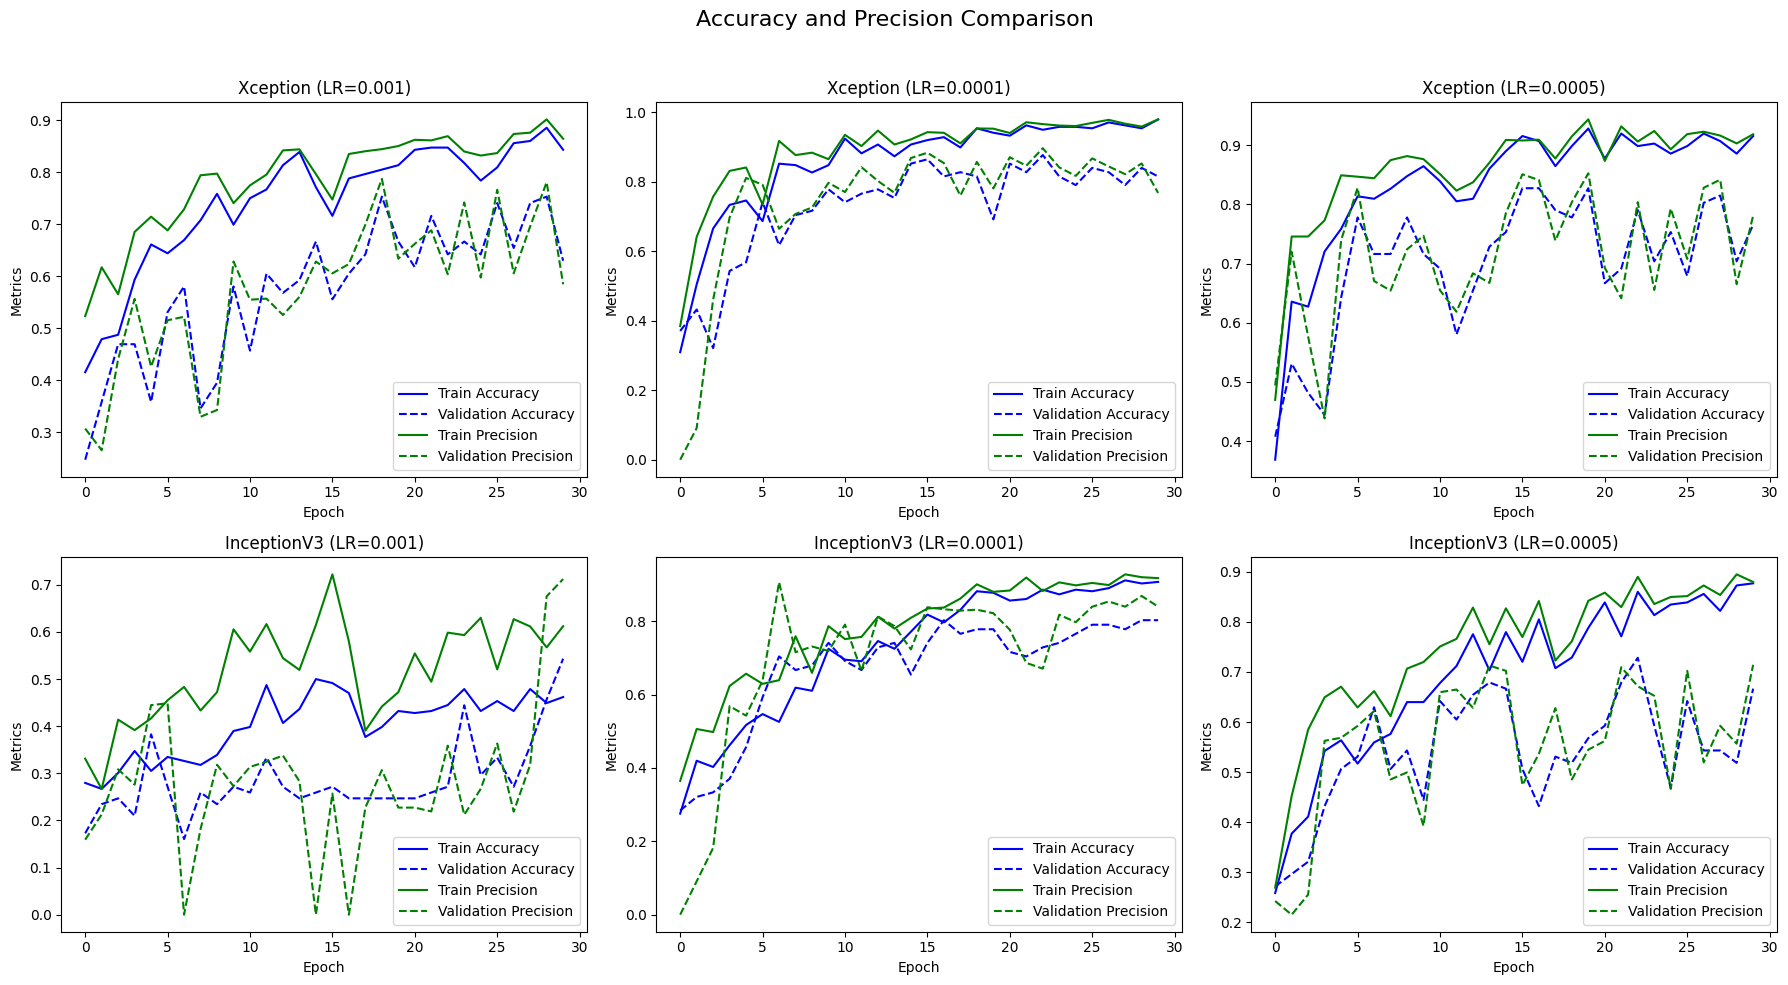

In [53]:
plot_accuracy_and_precision(historias,nombres)

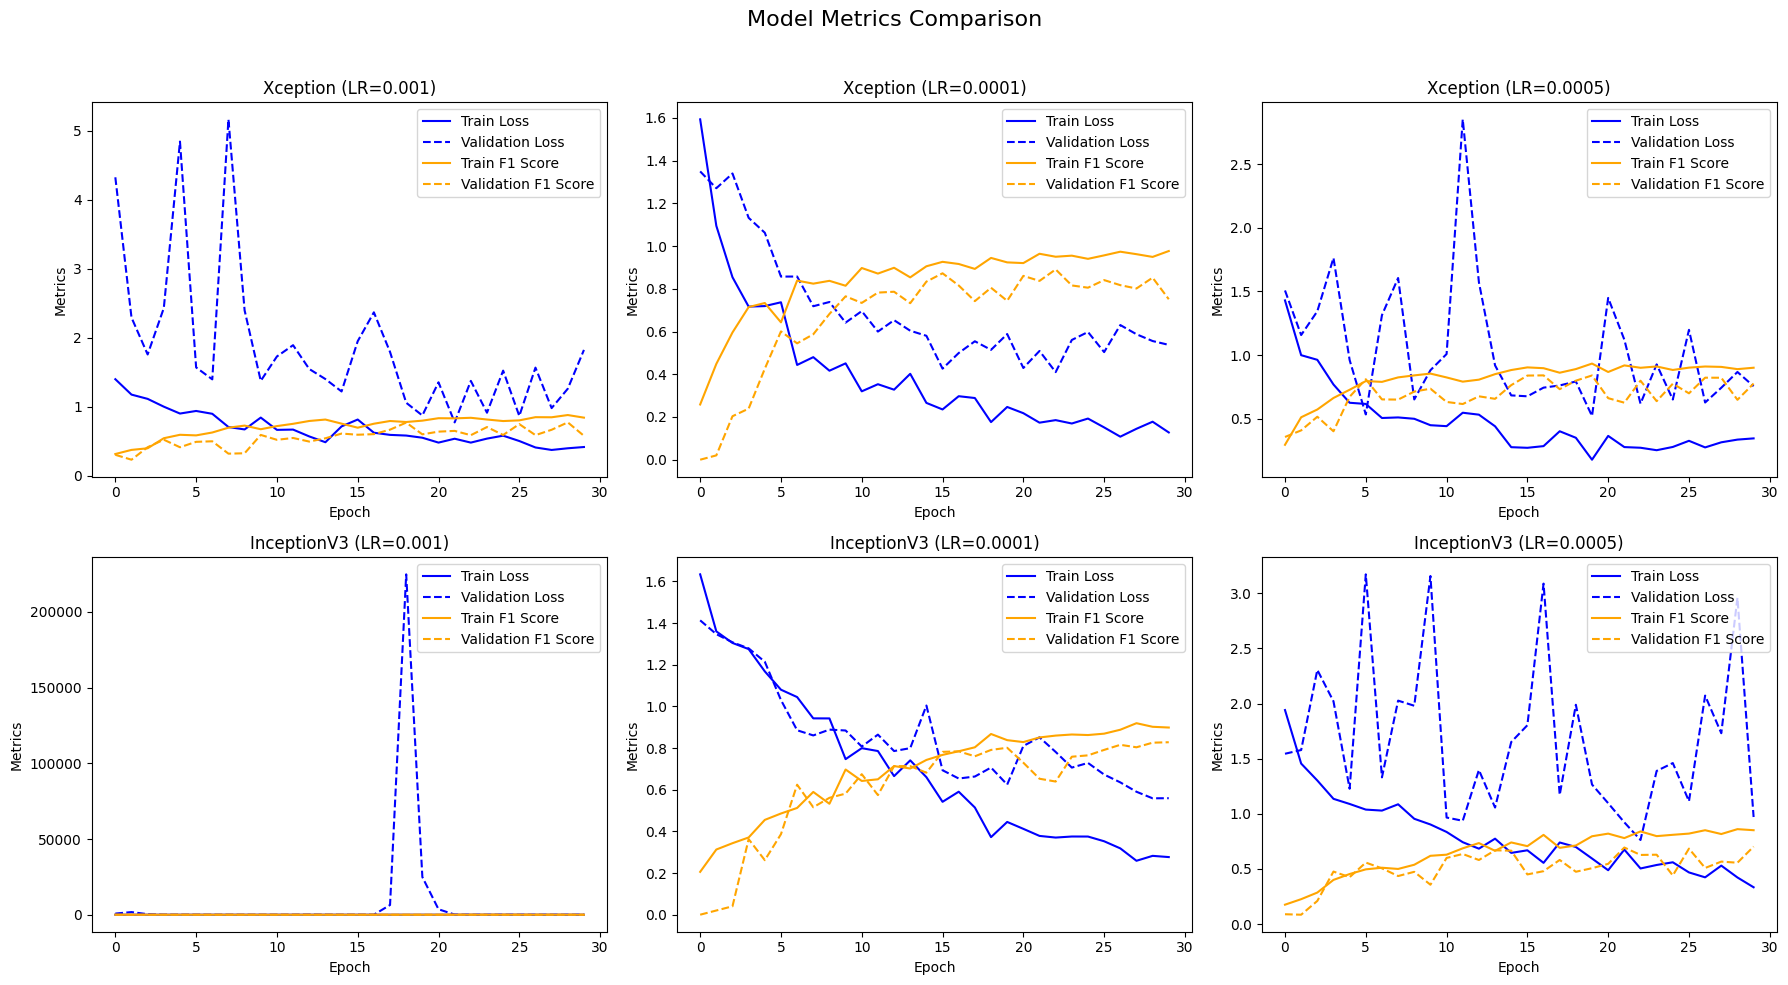

In [54]:
plot_metrics_loss_f1(historias,nombres)